In [18]:
import matplotlib.pyplot as plt
from torch import nn
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.mixture import GaussianMixture

from torchvision import datasets, transforms

In [19]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LR = 0.001
SEED = 42
DATASET_SAMPLES = 1000

# Define transformations for the data (normalize and convert to PyTorch tensor)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [20]:
class Autoencoder(nn.Module):

    def __init__(self,input_dim=2,h_dim=100,latent_dim=1,layers=2) -> None:
        '''
        Assume that layers is the number of hidden layers for decoder and encoder (not both)
        So in total there will be 2 * layers
        '''  
        super().__init__() 

        ## build encoder

        encoder_layers = [nn.Linear(input_dim,h_dim),nn.ReLU()]

        ## NOTE: no activation function after the layer that connects the last hidden layer of the encoder to the latent space
        for i in range(layers-2):
            encoder_layers.append(nn.Linear(h_dim,h_dim))
            encoder_layers.append(nn.ReLU())

        encoder_layers.append(nn.Linear(h_dim,latent_dim))

        self.encoder = nn.Sequential(*encoder_layers)


        ## build decoder

        decoder_layers = [nn.Linear(latent_dim,h_dim),nn.ReLU()]

        for i in range(layers-2):
            decoder_layers.append(nn.Linear(h_dim,h_dim))
            decoder_layers.append(nn.ReLU())

        decoder_layers.append(nn.Linear(h_dim,input_dim))

        self.decoder = nn.Sequential(*decoder_layers)



    def forward(self,x):
        return self.decoder(self.encoder(x))
    
    def encode(self,x):
        return self.encoder(x)
    
    def decode(self,x):
        return self.decoder(x)

In [21]:
def train(loader,model,optimizer,criterion,
          N   = 25,
          dev = 'cuda',
          vectorized_data_dimension=2,
          verbose=False):
    '''Train network

       Parameters:
           loader       Used to get data
           model        Model to be trained
           optimizer    Used to minimze errors
           criterion    Used to compute errors
      Keyword parameters:
          N             Number of epochs
          dev           Device - cpu or cuda
    '''
    Losses        = []

    for epoch in range(N):
        loss = 0
        for batch_features, _ in loader:
            # print(batch_features.shape)
            batch_features = batch_features.view(-1, vectorized_data_dimension).to(dev) ## NOTE: this may not work for other datasets 
            optimizer.zero_grad()
            outputs        = model(batch_features)
            train_loss     = criterion(outputs, batch_features)
            train_loss.backward()
            optimizer.step()
            loss += train_loss.item()

        Losses.append(loss / len(loader))
        
        if verbose:
            print(f'epoch : {epoch+1}/{N}, loss = {Losses[-1]:.6f}')

    return Losses

In [22]:
autoenc = Autoencoder(input_dim=2,h_dim=100,latent_dim=1,layers=3)
optimizer = torch.optim.Adam(autoenc.parameters(),lr = LR)
criterion     = torch.nn.MSELoss()

In [23]:
# Step 1: Generate the two moons dataset
X, y = make_moons(n_samples=DATASET_SAMPLES, noise=0.1, random_state=SEED)

# Step 2: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Step 3: Convert the NumPy arrays to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# Step 4: Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Step 5: Create DataLoader
batch_size = 16
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [24]:
def make_dataset(no_samples,noise,random_state):
    # Step 1: Generate the two moons dataset
    X, y = make_moons(n_samples=DATASET_SAMPLES, noise=0.1, random_state=SEED)

    # Step 2: Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

    # Step 3: Convert the NumPy arrays to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.LongTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.LongTensor(y_test)

    # Step 4: Create TensorDatasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Step 5: Create DataLoader
    batch_size = 16
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader,test_loader, X_train, X_test, y_train, y_test

In [25]:
Losses = train(train_loader,autoenc,optimizer,criterion,N= 100,dev = DEVICE)

In [58]:
def reconstruct(loader,model,criterion,
                N= 25,
                vectorized_data_dimension=2,
                dev = None,):
    
    loss = 0.0
    reconstructed_outputs = []
    with torch.no_grad():
        for i,(batch_features, _) in enumerate(loader):
            batch_features = batch_features.view(-1, vectorized_data_dimension).to(dev) ## BUG
            outputs        = model(batch_features) 
            reconstructed_outputs.append(outputs)
            test_loss      = criterion(outputs, batch_features)
            loss          += test_loss.item()
            

    return loss, torch.cat(reconstructed_outputs,dim=0)


def get_code_distribution(loader,model,
                vectorized_data_dimension=2,
                dev = None):
    
    code = []

    with torch.no_grad():
        for i,(batch_features, _) in enumerate(loader):
            print("Batch before reshape",batch_features.shape)
            # batch_features = batch_features.view(-1, vectorized_data_dimension).to(dev)
            batch_features = batch_features.view(batch_features.shape[0],-1).to(dev)
            print("batch features shape",batch_features.shape)
            batch_codes = model.encode(batch_features)
            code.append(batch_codes)

    print(len(code),code[0].shape)
    return np.array(torch.cat(code,dim=0).squeeze().tolist())


def sample_from_gmm(model,test_loader,dev=None,sample_multiplier=10):
    codes = get_code_distribution(test_loader,autoenc,dev=DEVICE)
    gm = GaussianMixture(n_components=2, random_state=SEED).fit(codes.reshape(-1,1))
    samples = gm.sample(16 * sample_multiplier)
    ## drop the labels or whatever those 1 and 0 are
    samples = samples[0]

    samples_batched = samples[:sample_multiplier * 16].reshape((sample_multiplier, 16))

    reconstructed = []

    for i in range(sample_multiplier):
        to_tensor_to_decoder = torch.tensor(samples_batched[i],dtype=torch.float32).reshape(-1,1)
        ## decode the samples
        decoded = model.decode(to_tensor_to_decoder.to(dev))

        reconstructed.append(decoded)

    return torch.cat(reconstructed,dim=0),codes
        


def plot_reconstructed_2d_data(real_data,reconstructed_data,show_plot=True,save_path=None):
    plt.figure(figsize=(10, 7))
    plt.scatter(real_data[:, 0], real_data[:, 1], c='b', label='Real')
    plt.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], c='r', label='Reconstructed')
    plt.legend()

    if save_path is not None:
        plt.savefig(save_path)

    if show_plot:
        plt.show()
    else:
        plt.close()

## Task 1.3

c:\Users\priot\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


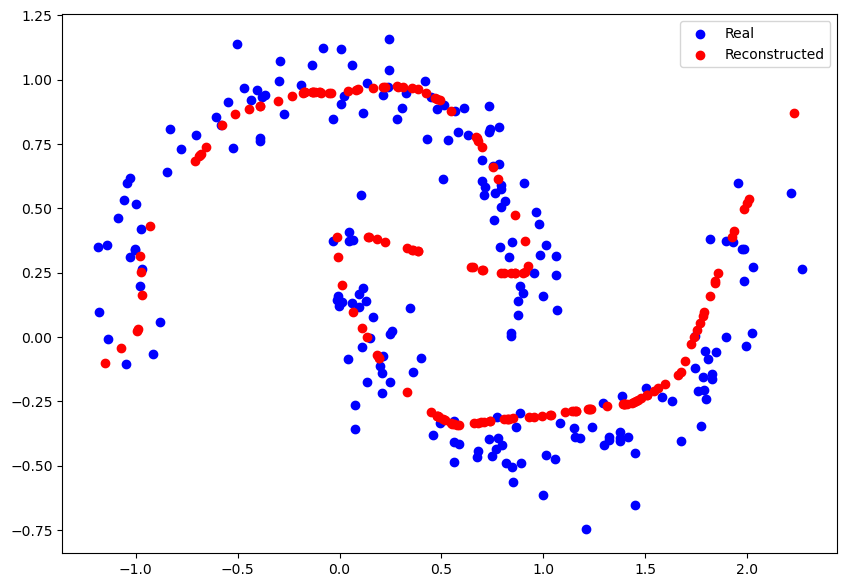

In [34]:
reconstructed_from_gmm,codes = sample_from_gmm(autoenc,test_loader,dev=DEVICE,sample_multiplier=10)
plot_reconstructed_2d_data(X_test,reconstructed_from_gmm.detach().cpu().numpy())

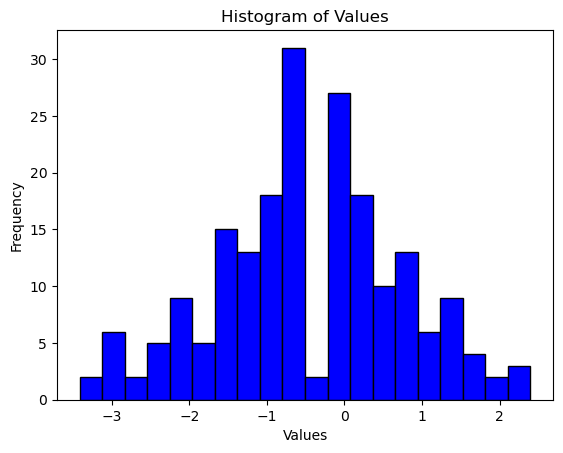

In [33]:
# Plotting the histogram
plt.hist(codes, bins=20, color='blue', edgecolor='black')

# Adding labels and title
plt.xlabel('codes')
plt.ylabel('Frequency')
plt.title('Histogram of Values')

# Display the plot
plt.show()

In [35]:
# loss, reconstructed_outputs = reconstruct(test_loader,autoenc,criterion,N=100,dev=DEVICE)

# plot_reconstructed_2d_data(X_test,reconstructed_outputs.cpu().numpy())

## Task 1.1 and 1.2

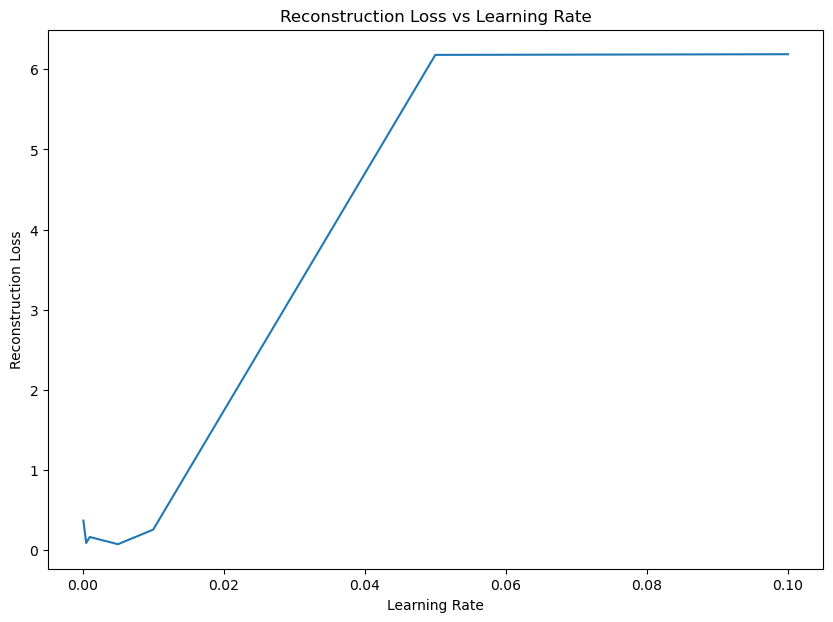

In [112]:
## Effect of learning rate on the reconstruction loss | should take around 4 mins

'''
Configuration: 

1000 samples of the dataset
*vary learning rate
keep autoencoder configuration constant
keep number of training and reconstruciton epochs constant
'''

lrs = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1]

reconstruction_losses_vs_lr = []

for lr in lrs:
    autoenc = Autoencoder(input_dim=2,h_dim=100,latent_dim=1,layers=3)
    criterion     = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(autoenc.parameters(),lr = lr)
    Losses = train(train_loader,autoenc,optimizer,criterion,N= 100,dev = DEVICE)
    loss, reconstructed_outputs = reconstruct(test_loader,autoenc,criterion,N=100,dev=DEVICE)
    reconstruction_losses_vs_lr += [loss]

    ## create a plot for each one and save the image
    plot_reconstructed_2d_data(X_test,reconstructed_outputs.cpu().numpy(),show_plot=False,save_path="autoenc_lrs/lrs_{}.png".format(lr))


## plot reconstruction loss vs learning rate
plt.figure(figsize=(10, 7))
plt.plot(lrs,reconstruction_losses_vs_lr)
plt.title("Reconstruction Loss vs Learning Rate")
plt.xlabel('Learning Rate')
plt.ylabel('Reconstruction Loss')
plt.show()

    



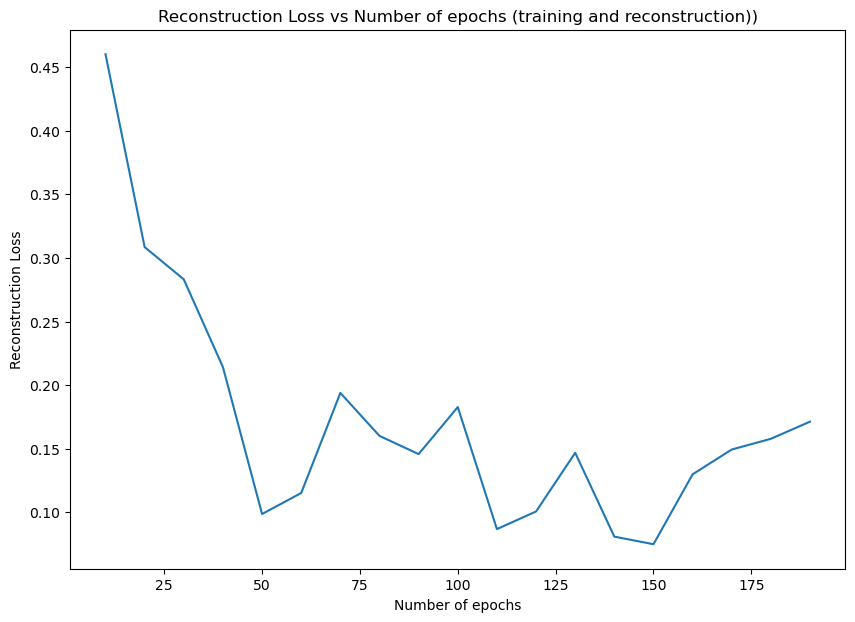

In [115]:
## Effect of number of epochs on the reconstruction loss

'''
Configuration: 

1000 samples of the dataset
lr: 0.001
keep autoencoder configuration constant
*vary number of training and reconstruciton epochs
'''


epochs = np.arange(10,200,10)

reconstruction_losses_vs_epochs = []

for epoch in epochs:
    autoenc = Autoencoder(input_dim=2,h_dim=100,latent_dim=1,layers=3)
    criterion     = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(autoenc.parameters(),lr = LR)
    Losses = train(train_loader,autoenc,optimizer,criterion,N= epoch ,dev = DEVICE)
    loss, reconstructed_outputs = reconstruct(test_loader,autoenc,criterion,N=epoch,dev=DEVICE)
    reconstruction_losses_vs_epochs += [loss]

    ## create a plot for each one and save the image
    plot_reconstructed_2d_data(X_test,reconstructed_outputs.cpu().numpy(),show_plot=False,save_path="autoenc_epochs/epoch_{}.png".format(epoch))



## plot reconstruction loss vs learning rate
plt.figure(figsize=(10, 7))
plt.plot(epochs,reconstruction_losses_vs_epochs)
plt.title("Reconstruction Loss vs Number of epochs (training and reconstruction))")
plt.xlabel('Number of epochs')
plt.ylabel('Reconstruction Loss')
plt.show()

    



In [117]:
## Effect of size of the dataset on the reconstruction loss

'''
Configuration: 

*vary number of samples of the dataset
lr: 0.001
keep autoencoder configuration constant
100 epochs for training and reconstruction
'''

sample_sizes = [1000,2000,3000,4000,5000,6000,7000,8000,9000,10000]
train_loaders = []
test_loaders = []
X_test_splits = []

for sample_size in sample_sizes:
    # Step 1: Generate the two moons dataset
    X, y = make_moons(n_samples=sample_size, noise=0.1, random_state=SEED)

    # Step 2: Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

    # Step 3: Convert the NumPy arrays to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.LongTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.LongTensor(y_test)

    # Step 4: Create TensorDatasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Step 5: Create DataLoader
    batch_size = 16
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    train_loaders.append(train_loader)
    test_loaders.append(test_loader)
    X_test_splits.append(X_test)


reconstruction_losses_vs_datasete_samples = []

for train_loader,test_loader,X_test in zip(train_loaders,test_loaders,X_test_splits):

    autoenc = Autoencoder(input_dim=2,h_dim=100,latent_dim=1,layers=3)
    criterion     = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(autoenc.parameters(),lr = LR)
    Losses = train(train_loader,autoenc,optimizer,criterion,N= epoch ,dev = DEVICE)
    loss, reconstructed_outputs = reconstruct(test_loader,autoenc,criterion,N=epoch,dev=DEVICE)
    reconstruction_losses_vs_datasete_samples += [loss]

    ## create a plot for each one and save the image
    ## BUG: the name of the file is not correct, it has to be multiplied with batch size to be accurate
    plot_reconstructed_2d_data(X_test,reconstructed_outputs.cpu().numpy(),show_plot=False,save_path="autoenc_dataset_size/size_{}.png".format(len(train_loader)))




## plot reconstruction loss vs learning rate
plt.figure(figsize=(10, 7))
plt.plot(sample_sizes,reconstruction_losses_vs_datasete_samples)
plt.title("Reconstruction Loss vs Number of samples in dataset")
plt.xlabel('Dataset size')
plt.ylabel('Reconstruction Loss')
plt.show()

    

KeyboardInterrupt: 

In [1]:
train_loader_gmm,test_loader_gmm, X_train_gmm, X_test_gmm, y_train_gmm, y_test_gmm = make_dataset(1000,0.1,SEED)



NameError: name 'make_dataset' is not defined

In [11]:
train_loader_1,test_loader_1, X_train_1, X_test_1, y_train_1, y_test_1 = make_dataset(5000,0.1,SEED)
train_loader_2,test_loader_2, X_train_2, X_test_2, y_train_2, y_test_2 = make_dataset(5000,0.2,SEED)

## Task 1.4


Reconstruction loss on dataset 2: 0.1814454714767635


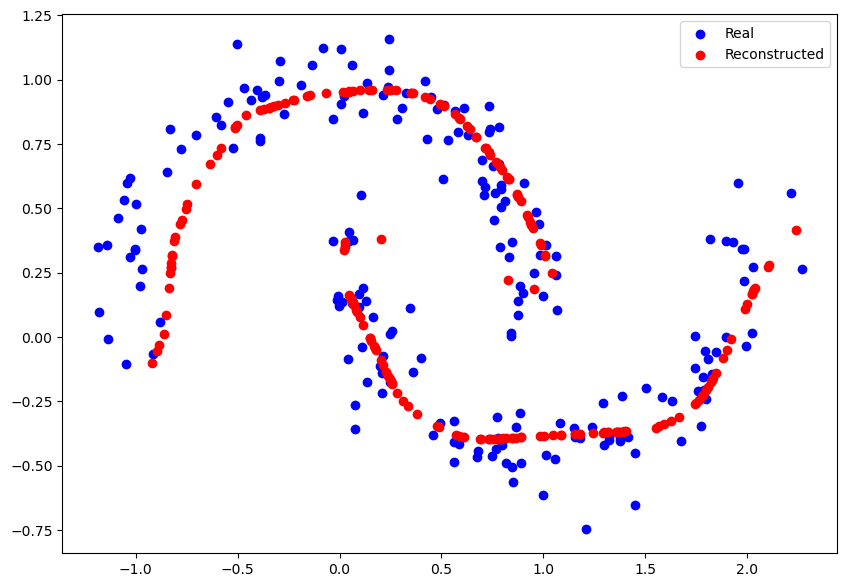

In [12]:

autoenc = Autoencoder(input_dim=2,h_dim=100,latent_dim=1,layers=3)
optimizer = torch.optim.Adam(autoenc.parameters(),lr = LR)
criterion     = torch.nn.MSELoss()


## train on the first dataset
Losses_1 = train(train_loader_1,autoenc,optimizer,criterion,N= 100,dev = DEVICE)


## reconstruct on the second dataset
loss, reconstructed_outputs = reconstruct(test_loader_2,autoenc,criterion,N=100,dev=DEVICE)

print("Reconstruction loss on dataset 2: {}".format(loss))

plot_reconstructed_2d_data(X_test_2,reconstructed_outputs.cpu().numpy())

## seems to work pretty good

## Task 1.5


Reconstruction loss on dataset 2: 0.15813623508438468


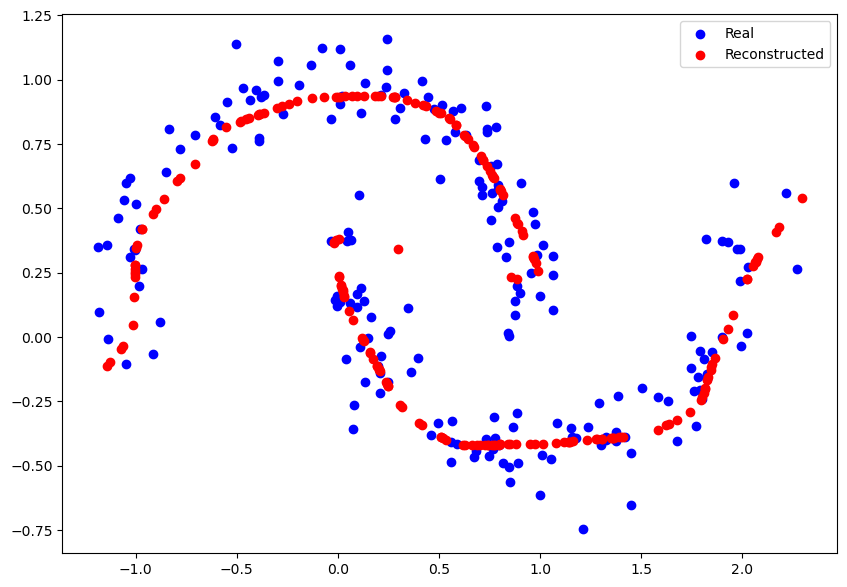

In [13]:

autoenc = Autoencoder(input_dim=2,h_dim=100,latent_dim=1,layers=3)
optimizer = torch.optim.Adam(autoenc.parameters(),lr = LR)
criterion     = torch.nn.MSELoss()

## train on noise 0.2 dataset
Losses_2 = train(train_loader_2,autoenc,optimizer,criterion,N= 100,dev = DEVICE)


## reconstruct on the 0.2 noise dataset
loss, reconstructed_outputs = reconstruct(test_loader_2,autoenc,criterion,N=100,dev=DEVICE)


print("Reconstruction loss on dataset 2: {}".format(loss))


plot_reconstructed_2d_data(X_test_2,reconstructed_outputs.cpu().numpy())

## to me it looks a bit like overfitting every cloud of points

## Task 3

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [39]:
# Download and load the MNIST training dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)

# Download and load the MNIST test dataset
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)


## Random forest classifier

In [38]:
def flatten_images(images):
    return images.view(images.size(0), -1)

X_train = torch.cat([flatten_images(images) for images, _ in train_loader], dim=0).numpy()
y_train = torch.cat([labels for _, labels in train_loader], dim=0).numpy()

X_test = torch.cat([flatten_images(images) for images, _ in test_loader], dim=0).numpy()
y_test = torch.cat([labels for _, labels in test_loader], dim=0).numpy()

# Step 4: Train RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=SEED)
rf_classifier.fit(X_train, y_train)

# Step 5: Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Step 6: Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "c:\Users\priot\anaconda3\Lib\site-packages\torch\utils\data\_utils\worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
           ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\priot\anaconda3\Lib\site-packages\torch\utils\data\_utils\fetch.py", line 54, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\priot\anaconda3\Lib\site-packages\torch\utils\data\_utils\collate.py", line 265, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\priot\anaconda3\Lib\site-packages\torch\utils\data\_utils\collate.py", line 142, in collate
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\priot\anaconda3\Lib\site-packages\torch\utils\data\_utils\collate.py", line 142, in <listcomp>
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\priot\anaconda3\Lib\site-packages\torch\utils\data\_utils\collate.py", line 150, in collate
    raise TypeError(default_collate_err_msg_format.format(elem_type))
TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>


## Bottleneck size influence

In [ ]:
bottleneck_sizes = [2,4,8]
reconstruction_losses_per_bs = []

for bs in bottleneck_sizes:
    autoenc = Autoencoder(input_dim=784,h_dim=100,latent_dim=bs,layers=3)
    optimizer = torch.optim.Adam(autoenc.parameters(),lr = LR)
    criterion     = torch.nn.MSELoss()

    # Training the autoencoder
    num_epochs = 5
    for epoch in range(num_epochs):
        for data in train_loader:
            images, _ = data
            images = images.view(images.size(0), -1).to(DEVICE)  # Flatten the images
            optimizer.zero_grad()
            outputs = autoenc(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()

        # print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

    loss, reconstructed_outputs = reconstruct(test_loader,autoenc,criterion,N=100,dev=DEVICE,vectorized_data_dimension=784)
    reconstruction_losses_per_bs += [loss]


for i in range(3):
    print("Bottle neck size: {}, Reconstruction loss: {}".format(bottleneck_sizes[i],reconstruction_losses_per_bs[i]))

In [60]:
autoenc = Autoencoder(input_dim=784,h_dim=100,latent_dim=2,layers=3)
optimizer = torch.optim.Adam(autoenc.parameters(),lr = 0.005)
criterion     = torch.nn.MSELoss()


# Training the autoencoder
num_epochs = 5
for epoch in range(num_epochs):
    for data in train_loader:
        images, _ = data
        images = images.view(images.size(0), -1).to(DEVICE)  # Flatten the images
        optimizer.zero_grad()
        outputs = autoenc(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/5], Loss: 0.1713
Epoch [2/5], Loss: 0.1839
Epoch [3/5], Loss: 0.1637
Epoch [4/5], Loss: 0.1507
Epoch [5/5], Loss: 0.1576


In [61]:
loss, reconstructed_outputs = reconstruct(test_loader,autoenc,criterion,N=100,dev=DEVICE,vectorized_data_dimension=784)


In [62]:
samples,codes = sample_from_gmm(autoenc,test_loader,dev=DEVICE,sample_multiplier=10)

# print(len(code),code[0].shape)

Batch before reshape torch.Size([64, 1, 28, 28])
batch features shape torch.Size([64, 784])
Batch before reshape torch.Size([64, 1, 28, 28])
batch features shape torch.Size([64, 784])
Batch before reshape torch.Size([64, 1, 28, 28])
batch features shape torch.Size([64, 784])
Batch before reshape torch.Size([64, 1, 28, 28])
batch features shape torch.Size([64, 784])
Batch before reshape torch.Size([64, 1, 28, 28])
batch features shape torch.Size([64, 784])
Batch before reshape torch.Size([64, 1, 28, 28])
batch features shape torch.Size([64, 784])
Batch before reshape torch.Size([64, 1, 28, 28])
batch features shape torch.Size([64, 784])
Batch before reshape torch.Size([64, 1, 28, 28])
batch features shape torch.Size([64, 784])
Batch before reshape torch.Size([64, 1, 28, 28])
batch features shape torch.Size([64, 784])
Batch before reshape torch.Size([64, 1, 28, 28])
batch features shape torch.Size([64, 784])
Batch before reshape torch.Size([64, 1, 28, 28])
batch features shape torch.Size

RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x1 and 2x100)

In [41]:
codes.shape

(3920000,)